### This is a notebook for testing

# MULTILATERATION + LINEAR REGRESSION

This code is related to Phase 1 of the algorithm. This phase is about positioning a device in the map knowing the latencies occured between it and the monitor nodes. The monitor nodes would map the distance using a linear regression computed from training data. Finally, all monitors would have estimated a distance between themselves and the target and a new pair of coordinates will be calculated through multilateration (a weightened centroid).



## 1) READING THE DATA

In [12]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from   mpl_toolkits.basemap import Basemap
%matplotlib inline
plt.style.use('ggplot')

PINGS_COUNT = 100

df = pd.read_csv("../OUTPUTS/PHASE_1/all_pings.csv",sep='|', encoding = "unicode_escape")

# Next columns contain values in a non-decimal type string (',' instead of '.')
seq = ['PING ' + str(i) for i in range(1,PINGS_COUNT+1)] + ['MIN RTT', 'AVG RTT', 'MAX RTT', 'MDEV'] 
df[seq] = df[seq].replace(',', '.',regex = True).astype("float")

df = df[df['TO CITY'] != 'Brentwood']
set_cities = df['FROM CITY'].drop_duplicates()
set_countries = df['FROM COUNTRY'].drop_duplicates()
thresMDEV = 3
thresDIST = 10000000
df

FILE PATH FROM COUNTRY  \
0       .\OUTPUTS1\Beauharnois-Frankfurt-pinginfo.txt       Canada   
1      .\OUTPUTS1\Beauharnois-Gravelines-pinginfo.txt       Canada   
2          .\OUTPUTS1\Beauharnois-London-pinginfo.txt       Canada   
3          .\OUTPUTS1\Beauharnois-Murcia-pinginfo.txt       Canada   
4      .\OUTPUTS1\Beauharnois-Strasbourg-pinginfo.txt       Canada   
...                                               ...          ...   
17602        .\OUTPUTS9\Warsaw-Frankfurt-pinginfo.txt       Poland   
17603       .\OUTPUTS9\Warsaw-Gravelines-pinginfo.txt       Poland   
17604           .\OUTPUTS9\Warsaw-London-pinginfo.txt       Poland   
17605           .\OUTPUTS9\Warsaw-Murcia-pinginfo.txt       Poland   
17606       .\OUTPUTS9\Warsaw-Strasbourg-pinginfo.txt       Poland   

         FROM CITY        FROM IP   FROM LAT   FROM LON      TO COUNTRY  \
0      Beauharnois   51.79.26.186  45.313978 -73.875834         Germany   
1      Beauharnois   51.79.26.186  45.313978 -73.875834          France   
2      Beauharnois   51.79.26.186  45.313978 -73.875834  United Kingdom   
3      Beauharnois   51.79.26.186  45.313978 -73.875834           Spain   
4      Beauharnois   51.79.26.186  45.313978 -73.875834          France   
...            ...            ...        ...        ...             ...   
17602       Warsaw  51.83.224.182  52.231958  21.006725         Germany   
17603       Warsaw  51.83.224.182  52.231958  21.006725          France   
17604       Warsaw  51.83.224.182  52.231958  21.006725  United Kingdom   
17605       Warsaw  51.83.224.182  52.231958  21.006725           Spain   
17606       Warsaw  51.83.224.182  52.231958  21.006725          France   

          TO CITY           TO IP     TO LAT  ...  HOPS 95  HOPS 96  HOPS 97  \
0       Frankfurt  141.95.106.115  50.110644  ...       48       48       48   
1      Gravelines   141.94.105.95  50.987070  ...       48       48       48   
2          London   51.89.225.218  51.507322  ...       48       48       48   
3          Murcia    88.20.36.106  37.992379  ...       43       43       43   
4      Strasbourg    51.91.150.94  48.584614  ...       48       48       48   
...           ...             ...        ...  ...      ...      ...      ...   
17602   Frankfurt  141.95.102.137  50.110644  ...       48       48       48   
17603  Gravelines   141.94.64.100  50.987070  ...       48       48       48   
17604      London   51.195.233.24  51.507322  ...       48       48       48   
17605      Murcia     88.20.39.66  37.992379  ...       44       44       44   
17606  Strasbourg    51.91.147.79  48.584614  ...       48       48       48   

       HOPS 98  HOPS 99  HOPS 100  MIN RTT  AVG RTT  MAX RTT   MDEV  
0           48       48        48   93.688   93.842   94.041  0.082  
1           48       48        48   78.831   78.971   79.203  0.070  
2           48       48        48   74.480   74.675   74.894  0.079  
3           43       43        43  113.530  113.841  114.526  0.163  
4           48       48        48   88.715   88.890   89.089  0.081  
...        ...      ...       ...      ...      ...      ...    ...  
17602       48       48        48   20.952   21.134   21.301  0.084  
17603       48       48        48   27.914   28.089   28.308  0.086  
17604       48       48        48   29.559   29.768   29.984  0.083  
17605       44       44        44   50.886   52.232   76.653  2.464  
17606       48       48        48   23.169   23.355   23.617  0.085  

[17558 rows x 216 columns]

## 2) CALCULATING AND COMPARING LINEAR REGRESSION LINES AND *BESTLINES*

A *bestline* is known as the best line fitting under all points from a set and providing the smallest distance to them.


### PROBLEM

Brentwood is a city's name located both in UK and US. *geopy* module identifies it as part of US when we want the one located in UK. Temporal solution is to ignore it, in the future it shall be renamed as Essex instead of Brentwood.
       

In [13]:
from scipy import optimize

def fit_below(x, y) :
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    x0, y0 = x[0] - 1, y[0]
    x -= x0
    y -= y0

    def error_function_2(b, x, y) :
        a = np.min((y - b) / x)
        return np.sum((y - a * x - b)**2)

    b = optimize.minimize(error_function_2, [0], args=(x, y)).x[0]

    a = np.min((y - b) / x)

    return a, b - a * x0 + y0

## BEST LINES

```get_regression_lines``` computes a dataframe containing the coefficients describing the bestline for each level, beeing this either a country or city (that is, we can compute a country or city-level bestline):
- ***level*** argument is either 'FROM COUNTRY' or 'FROM CITY'.
- ***inside_country*** flag indicates if the bestline must be computed considering all latencies (***false***) or just the ones originated by pings emmited from and targeted to the same country (***true***). 
- ***HEADER*** argument is to indicate which values the user is interested to consider for the bestline computation. We have the mean, max, min rtt, all rtts, the standard deviation and the number of hops (**NOTE**: the count of hops is badly calculated).
- ***thesMDEV*** and ***thresDIST*** are thresholds for standard deviation and distance in km. Any point surpassing any of these thresholds will not be considered for the bestline computation.
- ***show*** flag is used to indicate if we wish to plot the data.

In [14]:
#Using all rtts

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

#Valid HEADER values: 'AVG RTT', 'MAX RTT', 'MIN RTT', 'ALL RTT', 'MDEV', 'ALL HOP'
#Valid LEVEL values: 'FROM CITY', 'FROM COUNTRY'
def get_regression_lines(df, level = 'FROM CITY', inside_country = False, HEADER = 'AVG RTT', thresMDEV = 10, thresDIST = sys.maxsize, show = True):
    
    if HEADER not in ['AVG RTT', 'MAX RTT', 'MIN RTT', 'ALL RTT', 'MDEV', 'ALL HOP']:
        print("ERROR --> HEADER argument not valid. Value must be in {}".format(['AVG RTT', 'MAX RTT', 'MIN RTT', 'ALL RTT', 'MDEV', 'ALL HOP']))
        return
    
    if level not in ['FROM CITY', 'FROM COUNTRY']:
        print("ERROR -> LEVEL argument nor valid. Value must be in {}".format('FROM CITY', 'FROM COUNTRY'))
        return
        
    levels = df[level].drop_duplicates()
    c = 299792458 #Light's speed
    
    if show:
        size = len(levels)
        rows = int(size/2) + (1 if size % 2 == 1 else 0)
        cols = 2
        f, axes = plt.subplots(nrows = rows, ncols = cols, figsize = (20,20))
        i = 1

    bestlinesList = []
    regressionList = []

    for point in levels:
        X,Y = [], []
        
        dfAux = df[(df[level] == point) & (df['DISTANCE (KM)'] < thresDIST) & (df['MDEV'] < thresMDEV) & (df['TO COUNTRY'] != 'Spain')]
        
        if inside_country:
            country = dfAux['FROM COUNTRY'].iloc[0]
            print(country)
            dfAux = dfAux[dfAux['TO COUNTRY'] == country]

        for index,row in dfAux.iterrows():

            if HEADER in ('ALL RTT', 'ALL HOP'):
                auxX, auxY = [], []
                
                auxX = PINGS_COUNT * [row['DISTANCE (KM)']]
                
                if HEADER == 'ALL RTT':
                    val = 'PING'
                else:
                    val = 'HOPS'
                
                auxY = list(row[[val+ ' ' + str(i) for i in range(1,PINGS_COUNT+1)]])

                #Removing invalid values (if ping = -1, the target couldn't be reached, therefore it is discarded)
                sizeToRemove = auxY.count(-1)
                if (sizeToRemove > 0):
                    auxY = list(filter(lambda x: x != -1,auxY))
                    auxX = auxX[sizeToRemove:]

                X += auxX
                Y += auxY
                
        X = np.asarray(X if HEADER in ('ALL RTT', 'ALL HOP') else dfAux['DISTANCE (KM)'])
        Y = np.asarray(Y if HEADER in ('ALL RTT', 'ALL HOP') else dfAux[HEADER])
        
        if not X.any() or not Y.any():
            bestlinesList.append((None,None))
            print("|======> No points to plot")
            continue

        #Correlation coefficient
        my_rho = np.corrcoef(X,Y)

        #Best line
        a,b = fit_below(X,Y)
        bestlinesList.append((a,b))

        #Lineal regression
        #a2, b2 = np.polyfit(X, Y, deg = 1)
        #regressionList.append((a2,b2))
        
        if show:
            plt.subplot(rows,cols,i)
            i+=1
            #Scatter plot (rtt vs distance)
            plt.scatter(x = X, y = Y, s = 10)

            #Baseline plot (data travels at almost 2/3 of speed light)
            plt.plot(X,X*1000/(2/3*c)*1000,"r-",label = "baseline")

            #Bestline plot (best line fitting UNDER all points)
            plt.plot(X, a*X + b, "g-",label = "bestline")
            #Lineal regression
            #plt.plot(X, X*a2 + b2, "y-",label = "lineal regression")

            plt.title("{} (corr = {})".format(point,my_rho[0][1]))
            plt.xlabel(xlabel = "Distance (km)")
            val = 'RTT (ms)'
            if HEADER == 'ALL HOP':
                val = 'HOPS'
            plt.ylabel(ylabel = val)
            plt.legend(loc="upper left")

    bestlines = pd.DataFrame({'FROM':levels,'COEFS':bestlinesList})
    #regressionlines = pd.DataFrame({'FROM':levels,'COEFS':regressionList})

    #Separation for plots
    if show:
        plt.subplots_adjust(left=0.1,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.4, 
                            hspace=0.4)
        
    return bestlines

In [15]:
from scipy import stats

# Removes outliers through Z score
# Inputs dataframe and the variable from which outliers are to be removed
# Outputs df without the rows which were identified as outliers
def zscore(df, variable,zthres = 3, thresDIST = 5000):
    z = np.abs(stats.zscore(df[variable]))
    df['z'] = z
    df = df.loc[df['z'] < zthres]
    df = df.drop(columns='z')

    return df

#dfZ = zscore(df,'AVG RTT',thresDIST = 1500)
#print('Filas antes del zscore: {}'.format(df.shape[0]))
#print('Filas después del zscore: {}'.format(dfZ.shape[0]))

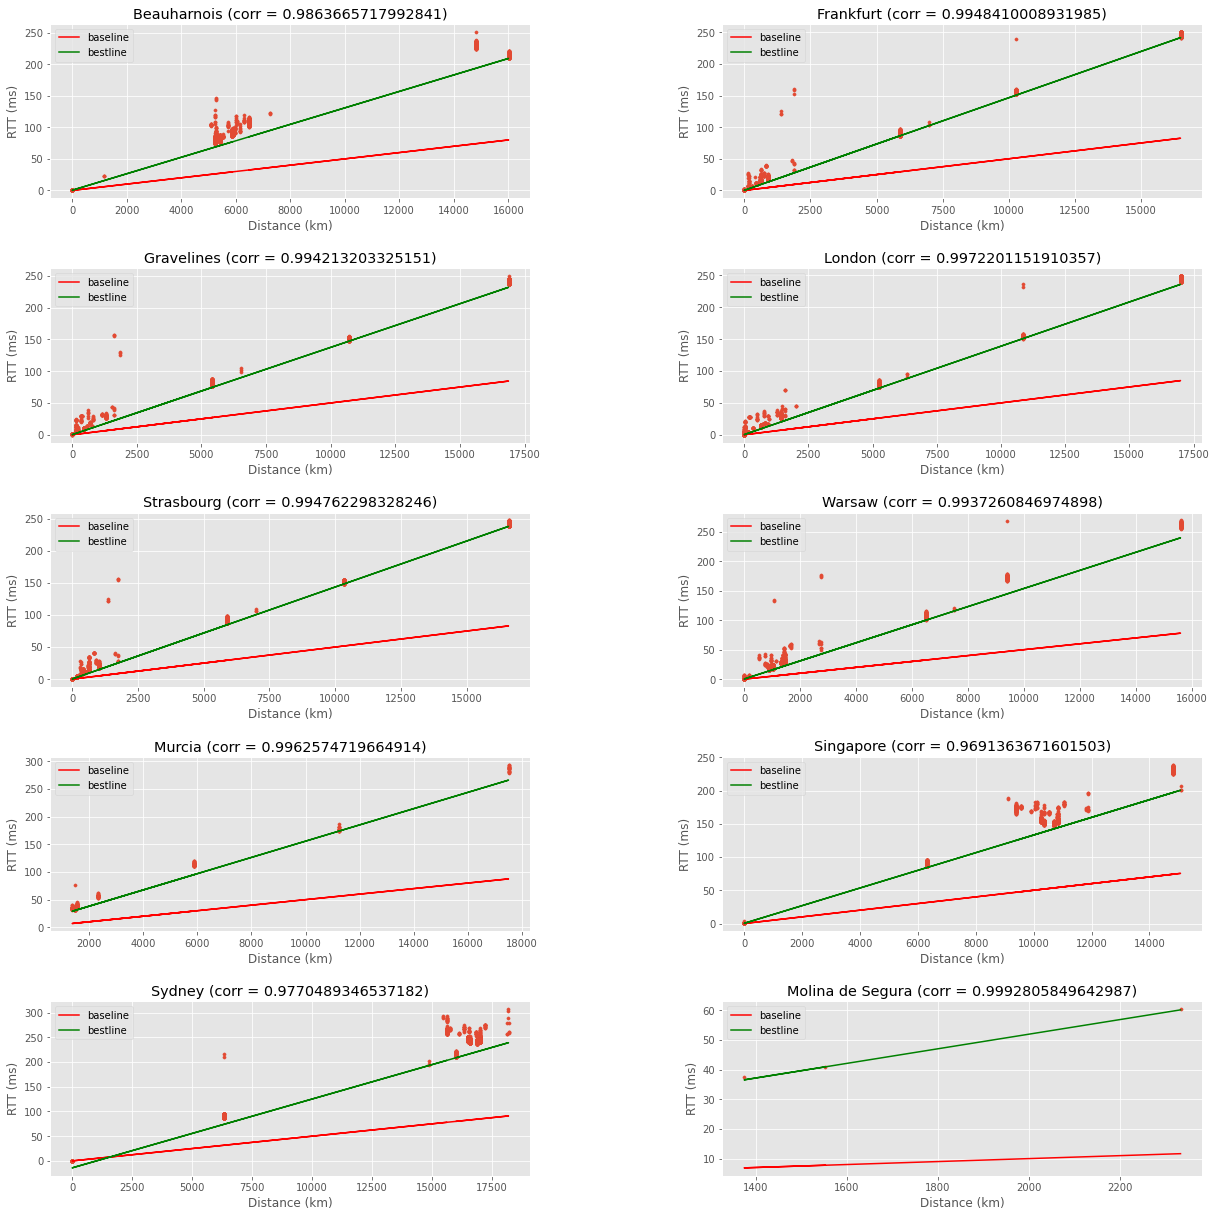

In [21]:
bestlines = get_regression_lines(df, level = 'FROM CITY', HEADER = 'AVG RTT', thresMDEV = 2, show = True)

## 3) DRAWING GREAT CIRCLES

The great-circle distance is the shortest distance between 2 points on the surface of a sphere. We use the function ***shaded_great_circle*** in order to draw a circle with a *dist* km radius and (lat_0,lon_0) as its center.

In order to calculate a coordinates point from (lat_0,lon_0), both separated by *dist* km, a method for calculating the destination point for a spherical Earth model is used (sinde *dist* was calculated using *great_circle* from *geopy*, which uses a spherical model of the Earth and results in an error of up to about 0.5%): ***calc_new_coord***.

In [17]:
from math import sqrt

# Returns the coordinates (lat2,lon2) located DIST km away from (lat,lon) in RAD radians
def calc_new_coord(lat, lon, rad, dist):
    """
    === SPHERICAL EARTH MODEL ===
    Calculate coordinate pair given starting point, radial and distance
    Method from: http://www.geomidpoint.com/destination/calculation.html
    """
    radiusEarth =  6372.7976 #km
    dist = dist/radiusEarth
    
    #Calculate the destination coordinates
    lat2 = np.arcsin(np.sin(lat)*np.cos(dist)+np.cos(lat)*np.sin(dist)*np.cos(rad))
    lon2 = lon+np.arctan2(np.sin(rad)*np.sin(dist)*np.cos(lat), np.cos(dist)-np.sin(lat)*np.sin(lat2))

    lat2 = np.rad2deg(lat2)
    lon2 = np.rad2deg(lon2)
    
    if (lon2 < -180):
        lon2 += 360
    elif (lon2 > 180):
        lon2 -=360
    
    return (lat2, lon2)
    

# Plots a circle of DIST km radius with (lat_0, lon_0) as center
def shaded_great_circle(m, lat_0, lon_0, dist=100, alpha=0.2, col='k'):  # dist specified in km
    x0,y0 = m(lon_0,lat_0)
    theta_arr = np.linspace(0, np.deg2rad(360), 100)
    lat_0 = np.deg2rad(lat_0)
    lon_0 = np.deg2rad(lon_0)

    coords_new = []

    for theta in theta_arr:
        coords_new.append(calc_new_coord(lat_0, lon_0, theta, dist))

    lat = [item[0] for item in coords_new]
    lon = [item[1] for item in coords_new]
    x, y = m(lon, lat)
    radius = sqrt(pow(y0-y[0],2)+pow(x0-x[0],2))
    m.plot(x, y, col)
    return ((x0,y0),radius)

## 4) GEOLOCATING

In [ ]:
from geopy.distance  import great_circle
from geopy.geocoders import Nominatim
import pytz

geolocator = Nominatim(user_agent="http")

```geolocate``` is a function used to test the algorithm's Phase 1 accuracy. A target is specified with a city's name and the latencies shown in the pings to it are mapped to distances by each monitor node using the their own bestline previously computed.
- ***target***: the city's name
- ***df_bestlines***: a tuple containing the dataframe with the data and the bestlines dataframe
- ***geolocator***: a ```geopy``` object used to extract the geolocation information of a set of coordinates
- ***thresDIST***: a threshold for the distance, therefore if a latency is mapped to a distance greater than this value, it won't be considered for the multilateration process.

The data is located in a csv file in ```TEST``` directory, which contains information about latencies which were not used for the training.

In [18]:
# Returns an estimation for the target's position in the cartesian's coordinate system
def multilateration(distances, positions, debug = False):
    def error(x, c, r):
        return sum([(np.linalg.norm(x - c[i]) - r[i]) ** 2 for i in range(len(c))])

    positions_len = len(positions)
    total_distances = sum(distances)
    # compute weight vector for initial guess
    if len(distances) == 1:
        weights = [1]
    else:
        weights = [1-d/total_distances for d in distances]
    #weights = [1000/d if d != 0 else 1 for d in distances]
    if (debug):
        print("weights = {}".format(weights))
    
    # initial estimation
    estimate_0 = sum([weights[i] * positions[i] for i in range(positions_len)])/sum(weights)
    return estimate_0
    # optimize distance from signal origin to border of spheres
    #return optimize.minimize(error, estimate_0, args=(positions, distances), method='Nelder-Mead').x
    
    
def geolocate(target, df_bestlines, geolocator, thresDIST = 6000, show_map = True, debug = True, show_real = False):
    df,bestlines = df_bestlines
    df = df[(df['TO CITY'] == target)]
    
    distances_to_target = []
    landmarks_pos = []
    
    m = Basemap(projection='lcc', resolution=None,
                    width=8E6, height=8E6, 
                    lat_0=45, lon_0=0)

    for city in df['FROM CITY'].drop_duplicates():
        X = df[df['FROM CITY'] == city]
        
        #if we are using all rtts
        #lon,lat,rtt = X['FROM LON'].iloc[0], X['FROM LAT'].iloc[0],np.nanmean(X[['PING ' + str(i) for i in range(1,PINGS_COUNT+1)]])

        #if we are using avg rtts
        lon,lat,rtt = X['FROM LON'].iloc[0], X['FROM LAT'].iloc[0],np.nanmean(X['AVG RTT'])
        
        x,y = m(lon,lat)
        
        (a,b) = bestlines[bestlines['FROM'] == city]['COEFS'].iloc[0]


        #estimated distance using bestline
        if rtt < 1:
            # In this case, the city belonging to the bestline that gave this rtt < 1 is the closest geoposition.
            # Nevertheless, we still draw a great circle of 100 km radius in order to see how it interacts with the rest
            dist = 1
        else:
            dist = (rtt-b)/a
            
        if show_map and dist <= thresDIST:
            plt.plot(x,y,'ok',markersize=5)
            #Great circle from real distance
            if (show_real):
                ((x0,y0),rad) = shaded_great_circle(m, lat, lon, dist=X['DISTANCE (KM)'].iloc[0], alpha=0.2, col='red')

        
        if (debug):
            print("============ {} ============".format(city))
            print("Best line equation: rtt = {}*dist + {}".format(a,b))
            print("(ESTIMATED) From {} to {} = {} km [{} ms]".format(city,target,dist,rtt))
            print("-> (REAL) From {} to {} = {} km".format(city,target,X['DISTANCE (KM)'].iloc[0],rtt))

            if dist < 0 or dist > thresDIST:
                print("--------------- DISCARDED ---------------")
                print()
                continue
            
            print()

        #Great circle from estimated distance
        ((x0,y0),rad) = shaded_great_circle(m, lat, lon, dist=dist, alpha=0.2, col='k')
        distances_to_target.append(0 if rtt < 1 else rad)
        landmarks_pos.append([x,y])


    target_pos = multilateration(distances_to_target,list(np.array(landmarks_pos)), debug = True)
    (eslonT,eslatT) = m(target_pos[0], target_pos[1],inverse = True)
    loc = geolocator.reverse("{}, {}".format(eslatT,eslonT), language = "en")
    
    if (debug):
        print()
        print('############################# RESULTS #############################')
        #print("Mean distance " + str(sum(distances_to_target)/len(distances_to_target)))
        print("Calculated geoposition = ({}, {})".format(eslatT,eslonT))
        print("Distance from target = {} km".format(great_circle((df[df['TO CITY'] == target]['TO LAT'].iloc[0],
                                                                  df[df['TO CITY'] == target]['TO LON'].iloc[0]),
                                                                            (eslatT,eslonT)).km))
        #print("Country code = " + "{}".format(loc.raw['address']['country_code']) if loc else 'unknown')
        #print("Country = " + loc.address.split(', ')[-1] if loc else 'unknown')
        print("Country = " + pytz.country_names[loc.raw['address']['country_code']] if loc else 'unknown')
        print("Complete address = " + loc.address if loc else 'unknown')

        print('###################################################################')
    
    if (show_map):
        plt.plot(target_pos[0], target_pos[1],'oy',markersize=5)
        x,y = m(df[df['TO CITY'] == target]['TO LON'].iloc[0],df[df['TO CITY'] == target]['TO LAT'].iloc[0])
        plt.plot(x, y,'ob',markersize=5)
    
    return loc, m



============ Beauharnois ============
Best line equation: rtt = 0.01306690243464598*dist + 0.27444098630546004
(ESTIMATED) From Beauharnois to London = 6145.824746812201 km [80.58133333333333 ms]
-> (REAL) From Beauharnois to London = 5252.573582044329 km
--------------- DISCARDED ---------------

============ Frankfurt ============
Best line equation: rtt = 0.014650327187005692*dist + 0.08783776635913987
(ESTIMATED) From Frankfurt to London = 1098.3331502446388 km [16.17877777777778 ms]
-> (REAL) From Frankfurt to London = 637.763765928864 km
--------------- DISCARDED ---------------

============ Gravelines ============
Best line equation: rtt = 0.013731127467719005*dist + 0.1713556755745227
(ESTIMATED) From Gravelines to London = 488.13098448232125 km [6.873944444444444 ms]
-> (REAL) From Gravelines to London = 167.15084691330097 km

============ London ============
Best line equation: rtt = 0.013874259451186473*dist + 0.24949935032186854
(ESTIMATED) From London to London = 320.2501

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


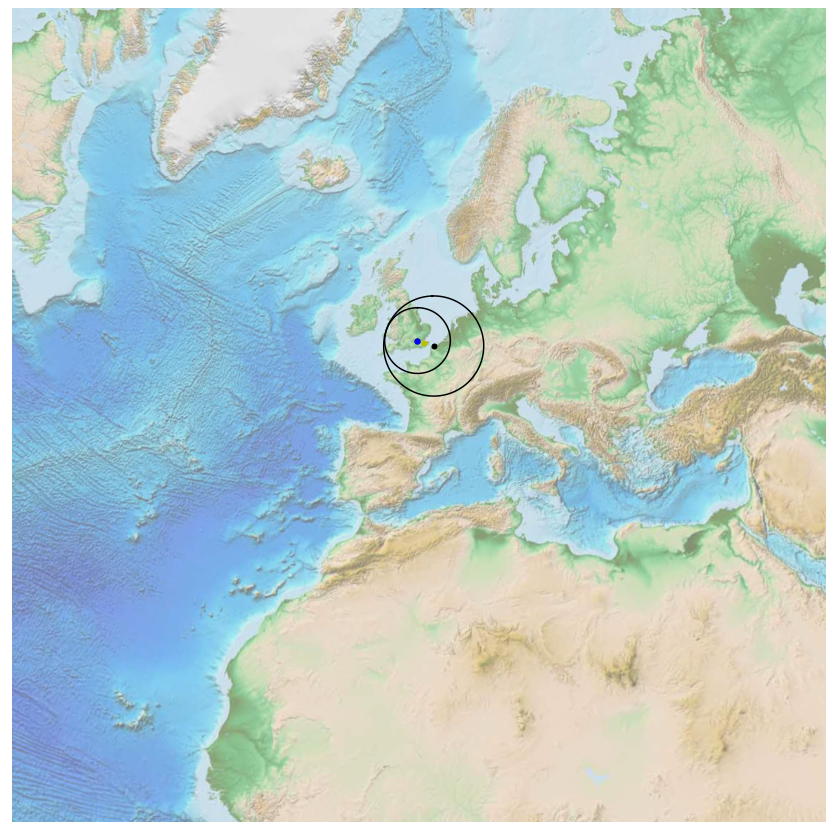

In [22]:
fig = plt.figure(figsize=(15, 15))

dfTest = pd.read_csv("../TEST/all_pings.csv",sep='|', encoding = "unicode_escape")
seq = ['PING ' + str(i) for i in range(1,PINGS_COUNT+1)] + ['MIN RTT', 'AVG RTT', 'MAX RTT', 'MDEV'] 
dfTest[seq] = dfTest[seq].replace(',', '.',regex = True).astype("float")
args = (dfTest,bestlines)
loc, MAP = geolocate('London', args , geolocator, thresDIST = 600)
MAP.etopo(scale=1, alpha=0.5)

============ Beauharnois ============
Best line equation: rtt = 0.01306690243464598*dist + 0.27444098630546004
(ESTIMATED) From Beauharnois to Berlin = 8243.363430552738 km [107.98966666666666 ms]
-> (REAL) From Beauharnois to Berlin = 6029.570921383968 km
--------------- DISCARDED ---------------

============ Frankfurt ============
Best line equation: rtt = 0.014650327187005692*dist + 0.08783776635913987
(ESTIMATED) From Frankfurt to Berlin = 1413.3128429608873 km [20.793333333333333 ms]
-> (REAL) From Frankfurt to Berlin = 422.4799640623624 km

============ Gravelines ============
Best line equation: rtt = 0.013731127467719005*dist + 0.1713556755745227
(ESTIMATED) From Gravelines to Berlin = 1927.4196082327908 km [26.637 ms]
-> (REAL) From Gravelines to Berlin = 791.761367075067 km

============ London ============
Best line equation: rtt = 0.013874259451186473*dist + 0.24949935032186854
(ESTIMATED) From London to Berlin = 2140.522701109292 km [29.947666666666663 ms]
-> (REAL) From 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


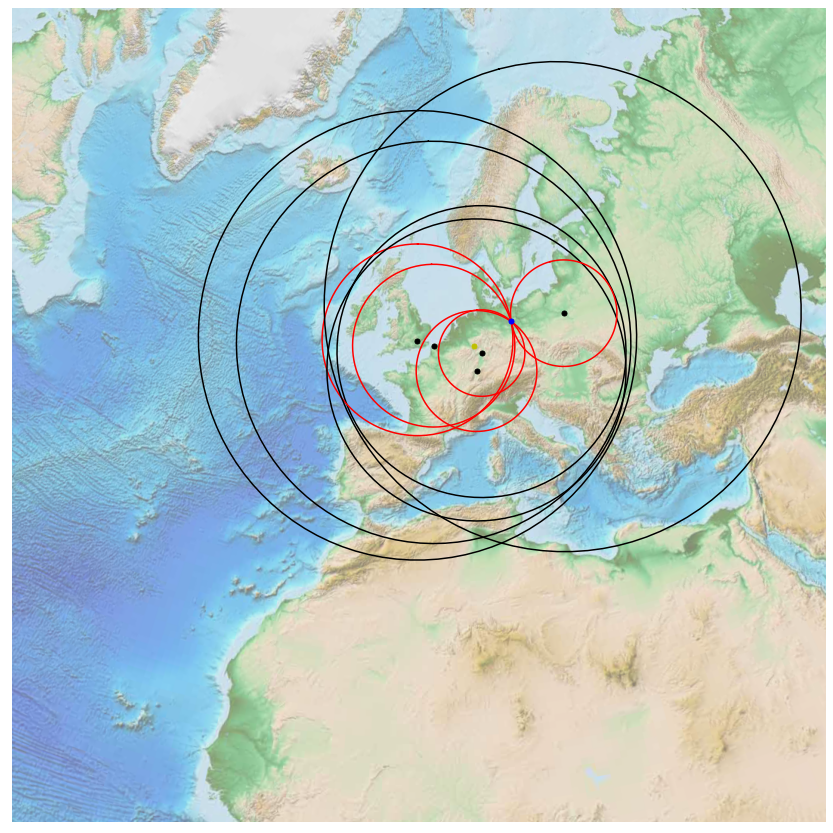

In [23]:
fig = plt.figure(figsize=(15, 15))
loc, MAP = geolocate('Berlin', args, geolocator, thresDIST = 5000, show_real = True)
MAP.etopo(scale=1, alpha=0.5)

============ Beauharnois ============
Best line equation: rtt = 0.01311003143157229*dist + -0.4159006136216392
(ESTIMATED) From Beauharnois to Munich = 7304.85667509466 km [95.351 ms]
-> (REAL) From Beauharnois to Munich = 6168.977378656474 km
--------------- DISCARDED ---------------

============ Frankfurt ============
Best line equation: rtt = 0.01464617403730407*dist + 0.15629379815465383
(ESTIMATED) From Frankfurt to Munich = 448.90264072374475 km [6.731000000000001 ms]
-> (REAL) From Frankfurt to Munich = 304.0685709164506 km

============ Gravelines ============
Best line equation: rtt = 0.013727802342204495*dist + 0.2069457984796116
(ESTIMATED) From Gravelines to Munich = 1001.6209338364002 km [13.957 ms]
-> (REAL) From Gravelines to Munich = 750.9153744343208 km

============ London ============
Best line equation: rtt = 0.013903835966047665*dist + -0.07132863572148912
(ESTIMATED) From London to Munich = 1242.2227945749062 km [17.200333333333333 ms]
-> (REAL) From London to Mu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


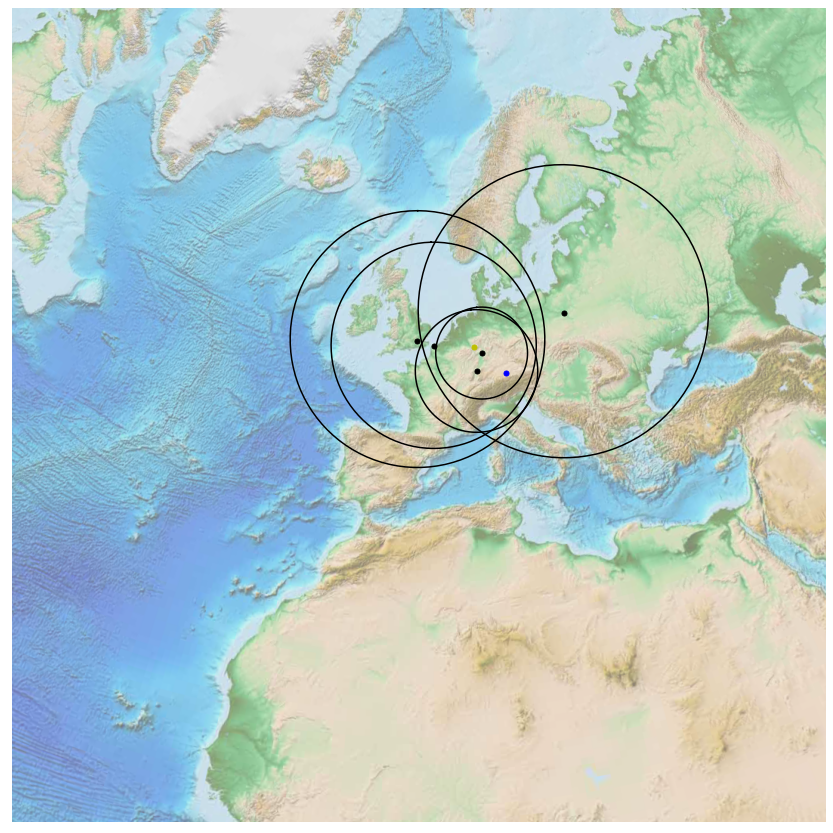

In [40]:
fig = plt.figure(figsize=(15, 15))
loc, MAP = geolocate('Munich', args, geolocator, thresDIST = 1600)
MAP.etopo(scale=1, alpha=0.5)

============ Beauharnois ============
Best line equation: rtt = 0.013115140306312908*dist + -0.4976754985857349
(ESTIMATED) From Beauharnois to Murcia = 8739.709642301115 km [114.1248426966292 ms]
-> (REAL) From Beauharnois to Murcia = 5891.617544599062 km
--------------- DISCARDED ---------------

============ Frankfurt ============
Best line equation: rtt = 0.014642610342524731*dist + 0.21503389197514022
(ESTIMATED) From Frankfurt to Murcia = 2599.2111297543347 km [38.27426966292135 ms]
-> (REAL) From Frankfurt to Murcia = 1556.028650713761 km
--------------- DISCARDED ---------------

============ Gravelines ============
Best line equation: rtt = 0.013723293357252468*dist + 0.2552072333997543
(ESTIMATED) From Gravelines to Murcia = 2337.150171085787 km [32.3286046511628 ms]
-> (REAL) From Gravelines to Murcia = 1467.4890888945104 km

============ London ============
Best line equation: rtt = 0.013879106849045902*dist + 0.19691773615638186
(ESTIMATED) From London to Murcia = 2546.480

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


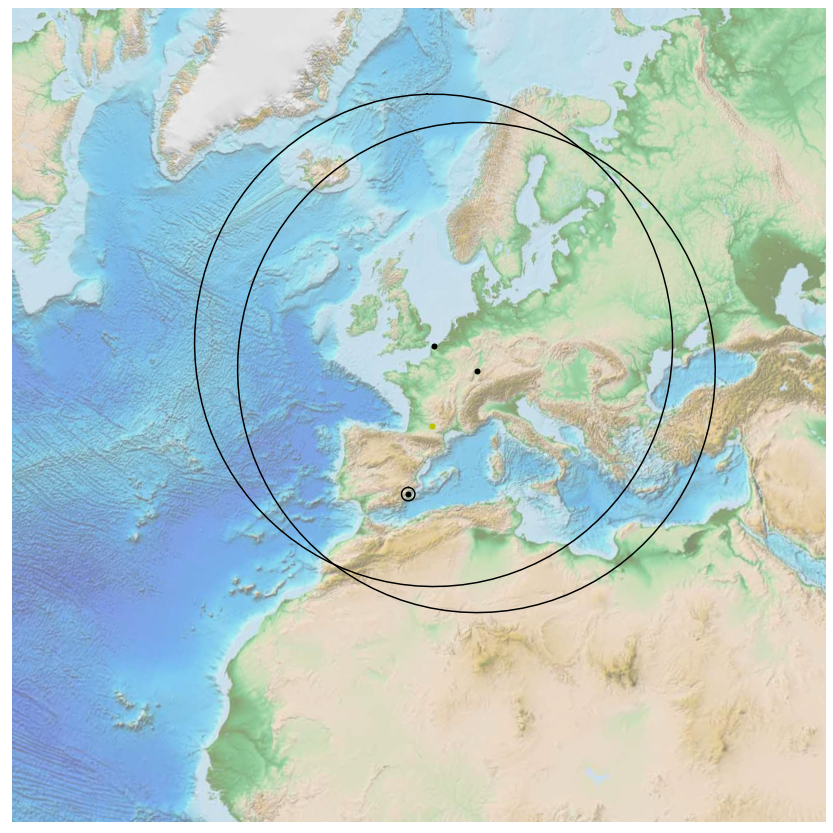

In [19]:
fig = plt.figure(figsize=(15, 15))
args = (df,bestlines)
loc, MAP = geolocate('Murcia', args, geolocator, thresDIST = 2400)
MAP.etopo(scale=1, alpha=0.5)

#### The rest of the notebook is pure testing, analysis of data for Phase 2 (not done yet)

# MULTILATERATION + CLUSTERS + LINEAR REGRESSION


## 1) READING THE DATA (SAME STEP)

In [3]:
PINGS_COUNT = 100

df2 = pd.read_csv("../OUTPUTS/PHASE_2/all_pings.csv",sep='|', encoding = "utf-8")

# Next columns contain values in a non-decimal type string (',' instead of '.')
seq = ['PING ' + str(i) for i in range(1,PINGS_COUNT+1)] + ['MIN RTT', 'AVG RTT', 'MAX RTT', 'MDEV'] 
df2[seq] = df2[seq].replace(',', '.',regex = True).astype("float")
df2[['FROM COUNTRY','TO COUNTRY']] = df2[['FROM COUNTRY','TO COUNTRY']].replace('Canda','Canada',regex = True)

df2

FILE PATH FROM COUNTRY  \
0      .\OUTPUTS45\Beauharnois-51.79.103.253-Aabenraa...       Canada   
1      .\OUTPUTS45\Beauharnois-51.79.103.253-Aalborg-...       Canada   
2      .\OUTPUTS45\Beauharnois-51.79.103.253-Aarau-18...       Canada   
3      .\OUTPUTS45\Beauharnois-51.79.103.253-Aaviku-1...       Canada   
4      .\OUTPUTS45\Beauharnois-51.79.103.253-Accra-17...       Canada   
...                                                  ...          ...   
20069  .\OUTPUTS45\Warsaw-51.68.146.247-ŽdinjaVas-91....       Poland   
20070  .\OUTPUTS45\Warsaw-51.68.146.247-Želiezovce-18...       Poland   
20071  .\OUTPUTS45\Warsaw-51.68.146.247-Žilina-37.61....       Poland   
20072  .\OUTPUTS45\Warsaw-51.68.146.247-Žiri-193.218....       Poland   
20073  .\OUTPUTS45\Warsaw-51.68.146.247-Živinice-213....       Poland   

         FROM CITY        FROM IP   FROM LAT   FROM LON  \
0      Beauharnois  51.79.103.253 -79.371600  43.631900   
1      Beauharnois  51.79.103.253 -79.371600  43.631900   
2      Beauharnois  51.79.103.253 -79.371600  43.631900   
3      Beauharnois  51.79.103.253 -79.371600  43.631900   
4      Beauharnois  51.79.103.253 -79.371600  43.631900   
...            ...            ...        ...        ...   
20069       Warsaw  51.68.146.247  52.231958  21.006725   
20070       Warsaw  51.68.146.247  52.231958  21.006725   
20071       Warsaw  51.68.146.247  52.231958  21.006725   
20072       Warsaw  51.68.146.247  52.231958  21.006725   
20073       Warsaw  51.68.146.247  52.231958  21.006725   

                   TO COUNTRY     TO CITY          TO IP   TO LAT  ...  \
0                     Denmark    Aabenraa    195.14.14.1  55.0443  ...   
1                     Denmark     Aalborg   195.43.138.1  57.0480  ...   
2                 Switzerland       Aarau   185.220.83.2  47.3925  ...   
3                     Estonia      Aaviku   195.34.212.2  59.3409  ...   
4                       Ghana       Accra  172.225.165.1   5.5560  ...   
...                       ...         ...            ...      ...  ...   
20069                Slovenia  Ždinja Vas   91.223.189.3  45.8460  ...   
20070                Slovakia  Želiezovce  188.190.100.1  48.0508  ...   
20071                Slovakia      Žilina    37.61.160.1  49.2231  ...   
20072                Slovenia        Žiri   193.218.94.2  46.0422  ...   
20073  Bosnia and Herzegovina    Živinice    213.91.64.1  44.4493  ...   

       HOPS 95  HOPS 96  HOPS 97  HOPS 98  HOPS 99  HOPS 100  MIN RTT  \
0           -1       -1       -1       -1       -1        -1  103.197   
1           -1       -1       -1       -1       -1        -1  102.878   
2           -1       -1       -1       -1       -1        -1   94.353   
3           -1       -1       -1       -1       -1        -1  112.823   
4           -1       -1       -1       -1       -1        -1  106.714   
...        ...      ...      ...      ...      ...       ...      ...   
20069       -1       -1       -1       -1       -1        -1   34.758   
20070       -1       -1       -1       -1       -1        -1   39.180   
20071       -1       -1       -1       -1       -1        -1   34.550   
20072       -1       -1       -1       -1       -1        -1   32.437   
20073       -1       -1       -1       -1       -1        -1   37.451   

       AVG RTT  MAX RTT   MDEV  
0      103.340  103.500  0.081  
1      102.959  103.036  0.047  
2       94.609   95.054  0.257  
3      113.139  115.305  0.723  
4      106.780  106.808  0.028  
...        ...      ...    ...  
20069   34.930   35.139  0.116  
20070   39.312   39.496  0.100  
20071   34.602   34.675  0.047  
20072   32.964   34.203  0.508  
20073   37.532   37.678  0.060  

[20074 rows x 216 columns]

## 2) COMPUTING *BESTLINE* REGRESSION PER CLUSTER

In [7]:
from sklearn.cluster import KMeans

def KMeans_score(df, city, Nc = range(1,20), thresMDEV = 10):
    X = np.array(df[(df['FROM CITY'] == city) & (df['TO CITY'] != city) & (df['MDEV'] <= thresMDEV)][['DISTANCE (KM)', 'AVG RTT']])
    kmeans = [KMeans(n_clusters=i) for i in Nc]
    kmeans
    score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    plt.plot(Nc,score)
    plt.xlabel(xlabel = 'Number of Clusters for {}'.format(city))
    plt.ylabel(ylabel = 'Score')
    plt.title('Elbow Curve')
    plt.show()


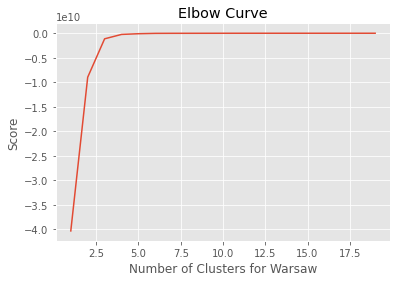

In [5]:
thresMDEV = 10
city = 'Warsaw'
KMeans_score(df, city)

Canada: 2 IPs
Germany: 99 IPs
France: 144 IPs
United Kingdom: 77 IPs
Singapore: 4 IPs
Australia: 4 IPs
Poland: 151 IPs


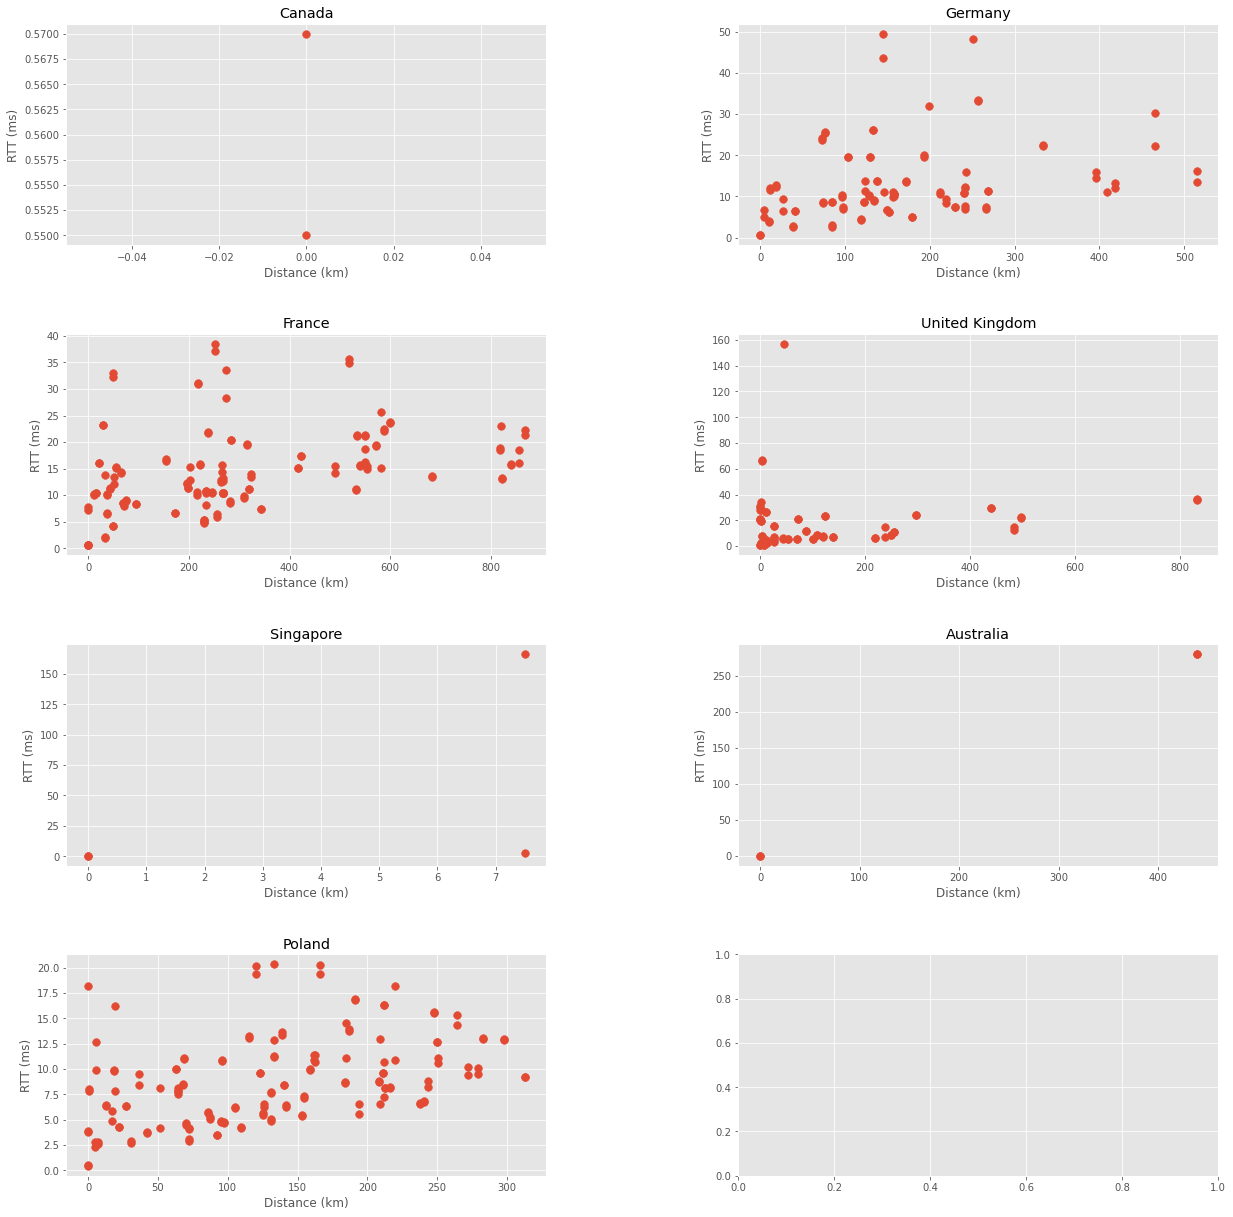

In [24]:
set_countries = df2[df2['FROM COUNTRY'] != 'Spain']['FROM COUNTRY'].drop_duplicates()
size_countries = len(set_countries)
rows = int(size_countries/2) + (1 if size_countries % 2 == 1 else 0)
cols = 2
f, axes = plt.subplots(nrows = rows, ncols = cols, figsize = (20,20))
i = 1
thresMDEV = 3

for country in set_countries:
    X = df2[(df2['FROM COUNTRY'] == country) & (df2['TO COUNTRY'] == country)][['DISTANCE (KM)','AVG RTT']]
    X = zscore(X, 'AVG RTT',zthres = 2)
    plt.subplot(rows,cols,i)
    i+=1
    plt.title("{}".format(country))
    plt.xlabel(xlabel = "Distance (km)")
    plt.ylabel(ylabel = "RTT (ms)")
    plt.scatter(x = X['DISTANCE (KM)'], y = X['AVG RTT'],s=60)
    print('{}: {} IPs'.format(country,X.shape[0]))
        
        
#Separation
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

Not enough points in Singapore for 5 clusters (4 pings in the country were made)
Not enough points in Australia for 5 clusters (4 pings in the country were made)


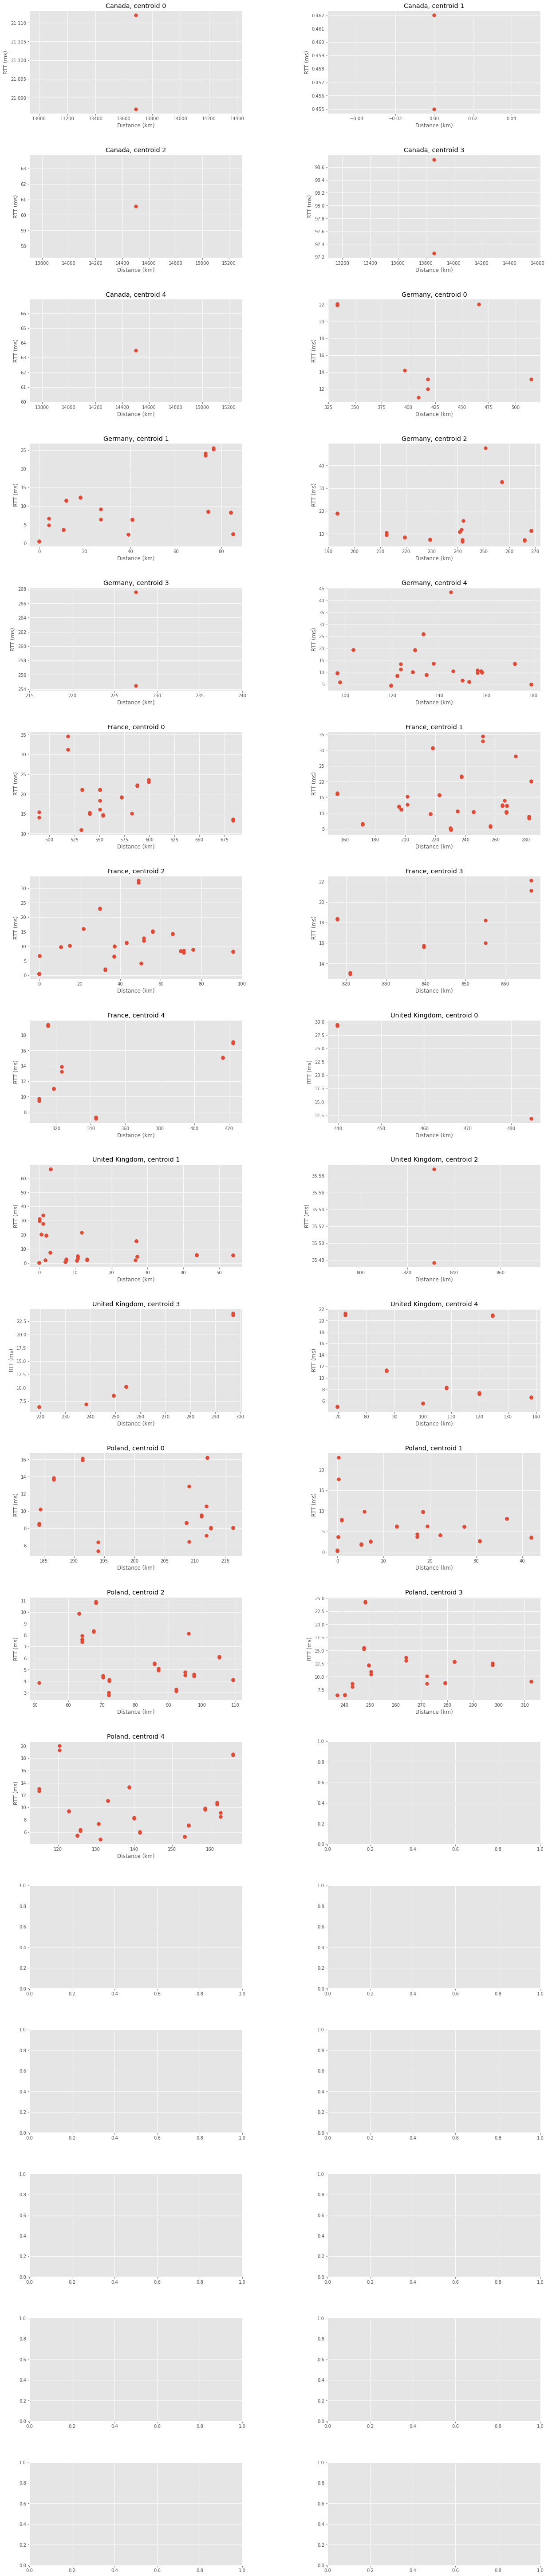

In [15]:
def fit_kmeans(df, nc, thresMDEV, thresDIST = sys.maxsize):
    X = np.array(df[(df['MDEV'] <= thresMDEV) & (df['DISTANCE (KM)'] <= thresDIST)][['DISTANCE (KM)', 'MIN RTT']])
    return KMeans(n_clusters=nc).fit(X), X


nc = 5
set_countries = df2[df2['FROM COUNTRY'] != 'Spain']['FROM COUNTRY'].drop_duplicates()
size_countries = len(set_countries)
rows = int(nc*size_countries/2) + (1 if nc*size_countries % 2 == 1 else 0)
cols = 2
f, axes = plt.subplots(nrows = rows, ncols = cols, figsize = (20,100))
i = 1
thresMDEV = 3

clusters = []
labels = []
dat = []
for country in set_countries:
    dfAux = df2[(df2['FROM COUNTRY'] == country) & (df2['TO COUNTRY'] == country)]
    npings = dfAux.shape[0]
    if npings < nc:
        clusters.append([])
        labels.append([])
        dat.append([])
        print("Not enough points in {} for {} clusters ({} pings in the country were made)".format(country,nc,npings))
        continue
    kmeans, X = fit_kmeans(dfAux,nc,thresMDEV)
    clusters.append(kmeans.cluster_centers_)
    labels.append(kmeans.labels_)
    dat.append(X)
    for cid in range(0,nc):
        plt.subplot(rows,cols,i)
        i+=1
        arr = np.asarray([X[i] for i in range(0,X.shape[0]) if kmeans.labels_[i] == cid])
        plt.title("{}, centroid {}".format(country,cid))
        plt.xlabel(xlabel = "Distance (km)")
        plt.ylabel(ylabel = "RTT (ms)")
        plt.scatter(x = arr[:,0], y = arr[:,1],s=60)
        
kmeansdf = pd.DataFrame({'COUNTRY':set_countries,'CLUSTERS':clusters,'LABELS':labels,'DATA':dat})        
        
        
#Separation
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)



In [341]:
kmeansdf

COUNTRY                                           CLUSTERS  \
0             Canada   [[0.0, 0.32960204081632655], [0.0, 0.429234375]]   
6            Germany  [[-9.237055564881302e-14, 0.40725730994151976]...   
12            France  [[481.1566851645621, 10.530154696132598], [2.2...   
18    United Kingdom  [[4.446371434467244, 2.5621209302325587], [206...   
30            Poland  [[1.9539925233402755e-14, 0.5423016759776538],...   
3414       Singapore  [[0.0, 0.3206901408450704], [0.0, 0.1964166666...   
3564       Australia       [[0.0, 0.18532258064516127], [0.0, 0.29572]]   

                                                 LABELS  \
0     [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, ...   
6     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
12    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
18    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
30    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3414  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...   
3564  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...   

                                                   DATA  
0     [[0.0, 0.336], [0.0, 0.401], [0.0, 0.538], [0....  
6     [[0.0, 0.422], [0.0, 0.357], [0.0, 0.428], [0....  
12    [[483.8938081757504, 10.204], [483.89380817575...  
18    [[0.0, 0.365], [0.0, 0.395], [0.0, 0.29], [0.0...  
30    [[0.0, 0.291], [0.0, 0.307], [0.0, 0.332], [0....  
3414  [[0.0, 0.356], [0.0, 0.334], [0.0, 0.343], [0....  
3564  [[0.0, 0.278], [0.0, 0.304], [0.0, 0.274], [0....

Text(0.5, 1.0, 'United Kingdom, centroid 0')

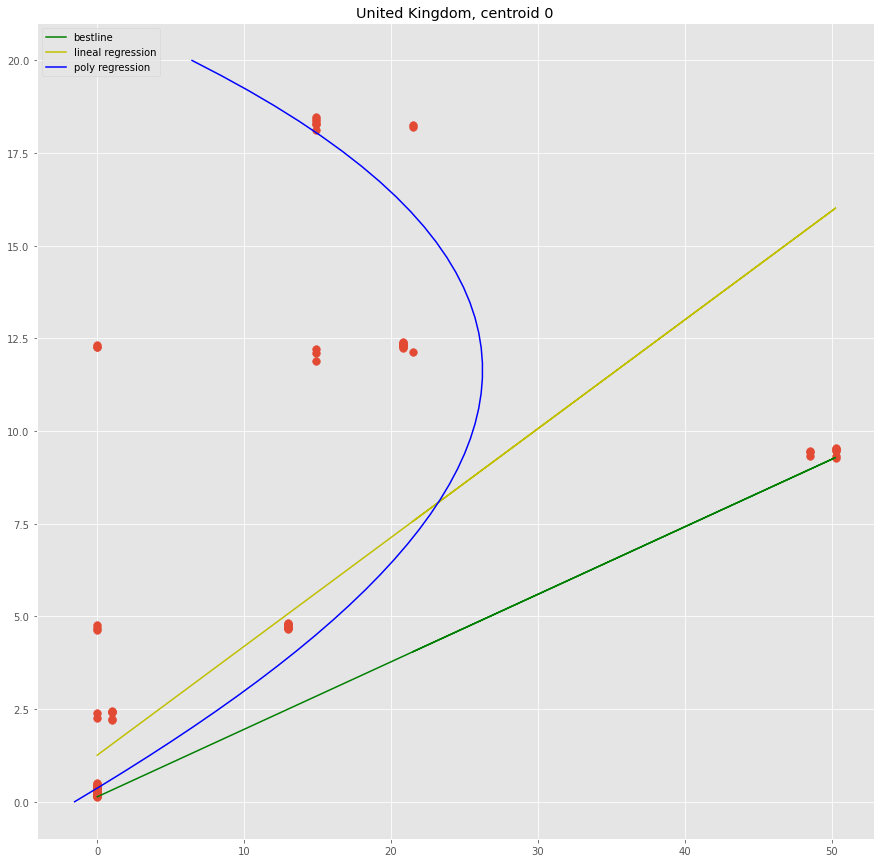

In [375]:
from sklearn.preprocessing import PolynomialFeatures

fig = plt.figure(figsize=(15, 15))
cid = 0
country = 'United Kingdom'
labels = kmeansdf[kmeansdf['COUNTRY'] == country]['LABELS'].to_numpy()[0]
dat = np.asarray(kmeansdf[kmeansdf['COUNTRY'] == country]['DATA'].to_numpy()[0])
dat = np.asarray([dat[i] for i in range(0,len(labels)) if labels[i] == cid])
X,Y = dat[:,0], dat[:,1]


plt.scatter(x = X, y = Y,s=60)

#Bestline
a,b = fit_below(X,Y)
plt.plot(X, a*X + b, "g-",label = "bestline")

#Lineal regression
a2, b2 = np.polyfit(X, Y, deg = 1)
plt.plot(X, X*a2 + b2, "y-",label = "lineal regression")

#Polynomial regression
mymodel = np.poly1d(np.polyfit(Y, X, 3))
myline = np.linspace(0, 20)
plt.plot(mymodel(myline) ,myline, "b-", label = "poly regression",)

plt.legend(loc="upper left")
plt.title("{}, centroid {}".format(country,cid))

In [376]:
abs((12.5-b)/a)

67.91250306627458

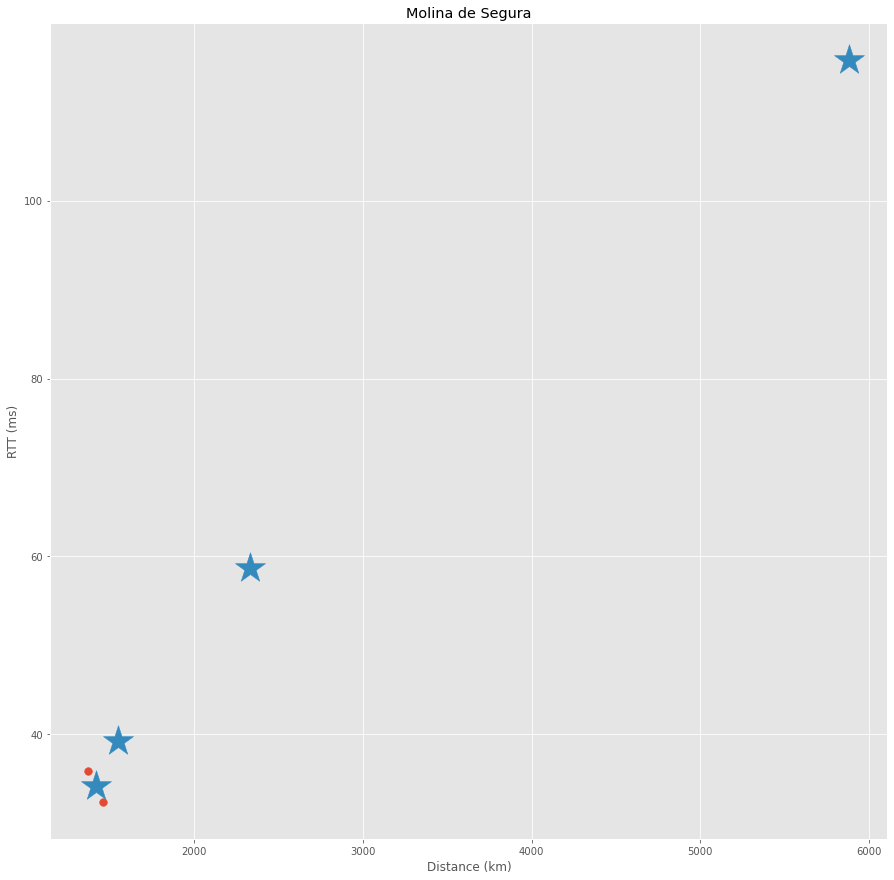

In [205]:
# Predicting the clusters
#labels = kmeans.predict(X)
# Getting the cluster centers
fig = plt.figure(figsize=(15, 15))
C = kmeans.cluster_centers_
plt.title("{}".format(city))
plt.xlabel(xlabel = "Distance (km)")
plt.ylabel(ylabel = "RTT (ms)")
plt.scatter(x = X[:,0], y = X[:,1],s=60)
plt.scatter(x = C[:,0], y = C[:,1], marker='*', s = 1000)

In [306]:
del kmeansdf

In [ ]:
#Pruebas con otros mapas


import folium
import folium.plugins
import geopandas
import io

text = '''
Zipcode Employees       Longitude Latitude
0   02021   174 -71.131057  42.228065
1   02026   193 -71.143038  42.237719
3   02109   45  -71.054027  42.363498
4   02110   14  -71.053642  42.357649
5   02111   30  -71.060280  42.350586
6   02113   77  -71.054618  42.365215
8   02115   116 -71.095106  42.343330
10  02118   318 -71.072103  42.339342
11  02119   804 -71.085268  42.323002
12  02120   168 -71.097569  42.332539
13  02121   781 -71.086649  42.305792
15  02124   1938    -71.066702  42.281721
16  02125   859 -71.053049  42.310813
17  02126   882 -71.090424  42.272444
19  02128   786 -71.016037  42.375254
21  02130   886 -71.114080  42.309087
22  02131   1222    -71.121464  42.285216
23  02132   1348    -71.168150  42.280316
24  02134   230 -71.123323  42.355355
25  02135   584 -71.147046  42.357537
26  02136   1712    -71.125550  42.255064
28  02152   119 -70.960324  42.351129
29  02163   1   -71.120420  42.367263
30  02186   361 -71.113223  42.258883
31  02199   4   -71.082279  42.346991
32  02210   35  -71.044281  42.347148
33  02215   83  -71.103877  42.348709
34  02459   27  -71.187563  42.286356
35  02467   66  -71.157691  42.314277
'''


boston = pd.read_csv(io.StringIO(text), sep='\s+')

boston_map = folium.Map([boston.Latitude.mean(), boston.Longitude.mean(), ], zoom_start=12)

incidents2 = folium.plugins.MarkerCluster().add_to(boston_map)

for latitude, longitude, employees in zip(boston.Latitude, boston.Longitude, boston.Employees):
    print(latitude, longitude, employees)
    folium.vector_layers.CircleMarker(
        location=[latitude, longitude],
        tooltip=str(employees),
        radius=employees/10,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'        
    ).add_to(incidents2)
    
boston_map.add_child(incidents2)

# display in web browser
import webbrowser
boston_map.save('map.html')
webbrowser.open('map.html')

Canada
|======> No points to plot
Germany
France
United Kingdom
Poland
Spain
|======> No points to plot
Singapore
|======> No points to plot
Australia
|======> No points to plot


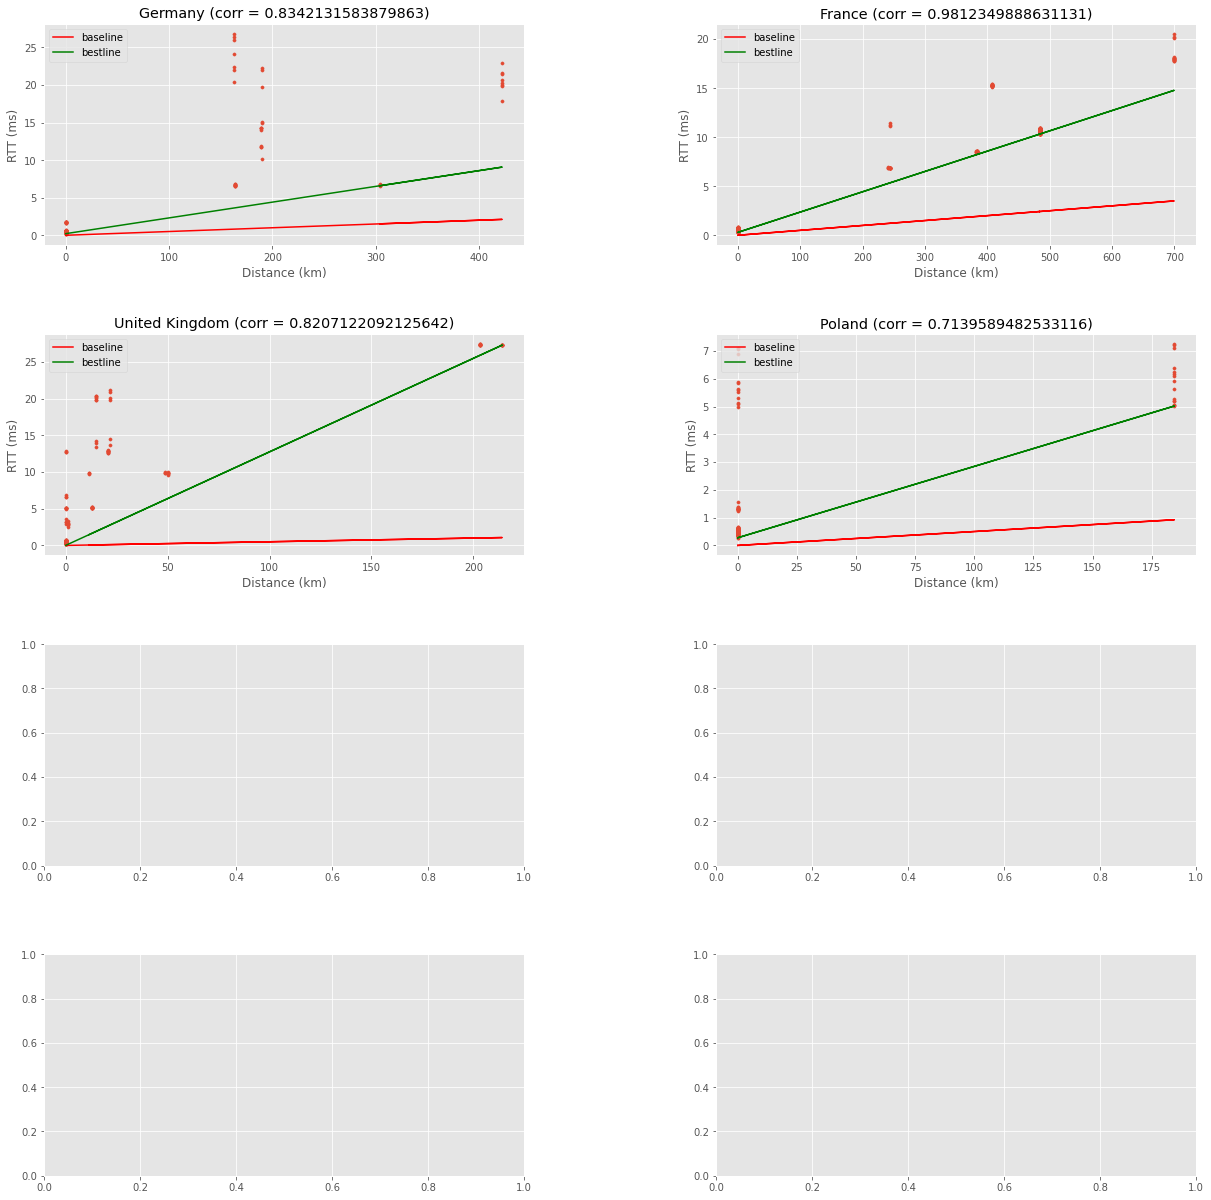

In [76]:
bestlines = get_regression_lines(df, level = 'FROM COUNTRY', inside_area = True, HEADER = 'AVG RTT', thresMDEV = 3, show = True)

In [27]:
'''country = 'United Kingdom'
dfAux = df[(df['DISTANCE (KM)'] < 100000000000) & (df['MDEV'] < 3)]
dfAuxCount = dfAux[(dfAux['FROM COUNTRY'] == country) & (dfAux['TO COUNTRY'] == country)]
dfAuxCount.boxplot(['AVG RTT'])'''

size_countries = len(set_countries)
rows = int(size_countries/2) + (1 if nc*size_countries % 2 == 1 else 0)
cols = 2
f, axes = plt.subplots(nrows = rows, ncols = cols, figsize = (30,100))
i = 1

for country in set_countries:
    plt.subplot(rows,cols,i)
    i+=1
    plt.title("{}".format(country))
    dfAux = df[(df['DISTANCE (KM)'] < 100000000000) & (df['MDEV'] < thresMDEV) & (df['FROM COUNTRY'] == country) & (df['TO COUNTRY'] == country)]
    dfAux.boxplot(['DISTANCE (KM)','AVG RTT'])

NameError: name 'nc' is not defined

<AxesSubplot:>

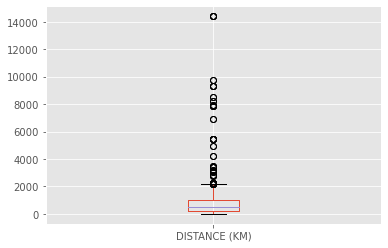

In [30]:
df[df['FROM COUNTRY'] == 'Germany'].boxplot(['DISTANCE (KM)'])